In [14]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
from datetime import datetime,timedelta
from xmovie import Movie
import nfft
import xrft
import cmath
import matplotlib as mpl
from matplotlib.lines import Line2D
import math

%matplotlib inline

In [400]:
input_path = 'E:/for_hendrik_20230316/'

velocity = xr.open_dataset(input_path + 'velocity_raw_filtered.nc')


spectral_u = xr.open_dataset(input_path + 'spectral_u.nc')
spectral_u['f_k'] = spectral_u.f_k_real + 1j*spectral_u.f_k_real

spectral_v = xr.open_dataset(input_path + 'spectral_v.nc')
spectral_v['f_k'] = spectral_v.f_k_real + 1j*spectral_v.f_k_real

spectral_rotary = xr.open_dataset(input_path + 'spectral_rotary.nc')
spectral_rotary['f_k'] = spectral_rotary.f_k_real + 1j*spectral_rotary.f_k_real


In [2]:
# input_path = '/home/hgrosselindemann/Documents/for_hendrik_20230316/'

# input_path = '/Users/2311043/Documents/GitHub/TORI/'
input_path = 'E:/for_hendrik_20230316/'

grid_data = scipy.io.loadmat(input_path + 'TOROS_grids_f.mat')
# vel_data = scipy.io.loadmat(input_path + '201503.mat')

In [3]:
time = np.arange(datetime(2013,1,1,0,0,0), datetime(2018,1,1,0,0,0), timedelta(hours=1)).astype(datetime)

In [4]:
files = []
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
for year in np.arange(2013,2018):
    for month in months:

        files.append(input_path + f'{year}{month}.mat')

In [5]:
vel_u = scipy.io.loadmat(files[0])['u0_monthly']
vel_v = scipy.io.loadmat(files[0])['v0_monthly']


for file in files[1:]:
    u = scipy.io.loadmat(file)['u0_monthly']
    v = scipy.io.loadmat(file)['v0_monthly']
    
    vel_u = np.concatenate((vel_u,u),axis=-1)
    vel_v = np.concatenate((vel_v,v),axis=-1)    

In [6]:
flag = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0'])
},data_vars={
    'flag':(['y','x'],grid_data['flag0'])
})

velocity = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0']),
    'time':(['time'],time)
},data_vars={
    'u':(['y','x','time'],vel_u/100),
    'v':(['y','x','time'],vel_v/100)
})

velocity = velocity.transpose('time','y','x')

velocity['u'] = velocity['u'].where(flag.flag==0)
velocity['v'] = velocity['v'].where(flag.flag==0)
velocity['abs'] = np.sqrt(velocity['u']**2 + velocity['v']**2)

# means

In [392]:
u_dashed = velocity.u - velocity.u.mean(dim='time')
v_dashed = velocity.v - velocity.v.mean(dim='time')

eke_mean = ((u_dashed**2).mean(dim='time') + (v_dashed**2).mean(dim='time'))/2

In [11]:
eke = (velocity.u**2 + velocity.v**2)/2 - (velocity.u.mean(dim='time')**2 + velocity.v.mean(dim='time')**2)/2

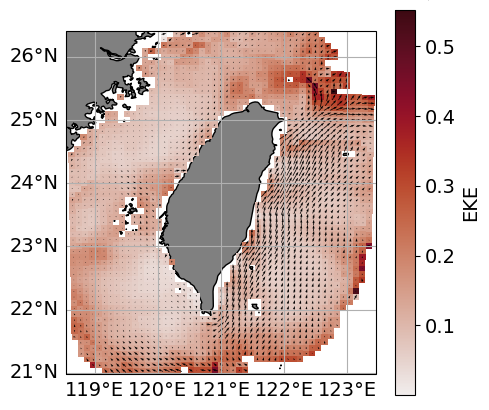

In [393]:
# fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})

eke_mean.plot(ax=ax1,x='lon',y='lat',cmap=cmo.amp,cbar_kwargs={'label':'EKE'})
velocity.mean(dim='time').plot.quiver('lon','lat','u','v',ax=ax1)
ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

# Data Coverage

In [305]:
nan_mask = ~np.isnan(velocity.u)
data_coverage = np.sum(nan_mask,axis=0)/len(velocity.time)
velocity['coverage'] = data_coverage

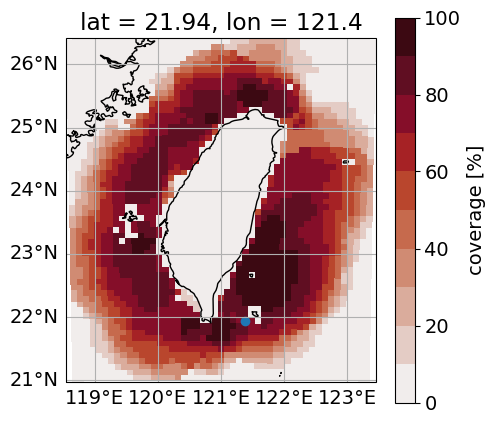

In [306]:
fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})

(velocity.coverage*100).plot(ax=ax1,x='lon',y='lat',levels=np.arange(0,110,10),cmap=cmo.amp,cbar_kwargs={'label':'coverage [%]'})

# ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

# for x,y in zip(x_idx,y_idx):
#     xr.plot.scatter(ds=velocity.isel(x=x,y=y),x='lon',y='lat',color='b')
xr.plot.scatter(ds=velocity.isel(x=28,y=10),x='lon',y='lat')
# plt.scatter(longitudes,latitudes,transform=ccrs.PlateCarree(),marker='x')

# Movie

In [9]:
fig = plt.figure(figsize=(10,10))

def custom_plotfunc(ds,fig,tt,framedim='time',**kwargs):
    ax = fig.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    ds.isel({framedim:tt}).plot.quiver('lon','lat','u','v',ax=ax)
    ax.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
    ax.gridlines(draw_labels=True)
    return None,None
    
# mov = Movie(velocity,custom_plotfunc,input_check=False)
# mov.save('movie_2015.mp4',overwrite_existing=True,framerate=8)

<Figure size 1000x1000 with 0 Axes>

# De-mean and De-trend

In [7]:
def demean_xarray(da,dim):
    return da - da.mean(dim=dim)

def detrend_xarray(da):
    dt = xr.apply_ufunc(
                linear_detrend,
                da,
                input_core_dims=[['time']],
                output_core_dims=[['time']],
                vectorize=True,
                output_dtypes=[da.dtype],
                dask="parallelized",
            )
    dt = dt.transpose('time','y','x')
    return dt

def linear_detrend(da,order=1):
    '''
    linear detrend of non uniform data on a uniform grid with nan values
    
    change order to increase order of fittet polynomial
    
    '''
    ds = da.copy()
    mask = ~np.isnan(ds)
    if mask.sum() == 0:
        return ds
    else:
        ds_masked = ds[mask]
        time_masked = np.arange(0,len(ds))[mask]
        coeff = np.polyfit(time_masked, ds_masked, order)
        trend = np.polyval(coeff, time_masked)
        detrended = ds_masked - trend
        ds[mask] = detrended
        return ds

In [8]:
velocity['u_demeaned'] = demean_xarray(velocity.u,dim='time')
velocity['u_detrended'] = detrend_xarray(velocity['u_demeaned'])

velocity['v_demeaned'] = demean_xarray(velocity.v,dim='time')
velocity['v_detrended'] = detrend_xarray(velocity['v_demeaned'])

In [9]:
velocity.to_netcdf(input_path + 'velocity_raw_detrended.nc')

# interpolation

In [22]:
test = velocity.u[:,10,10].copy()
dummy = test.interpolate_na(dim='time',method='linear')

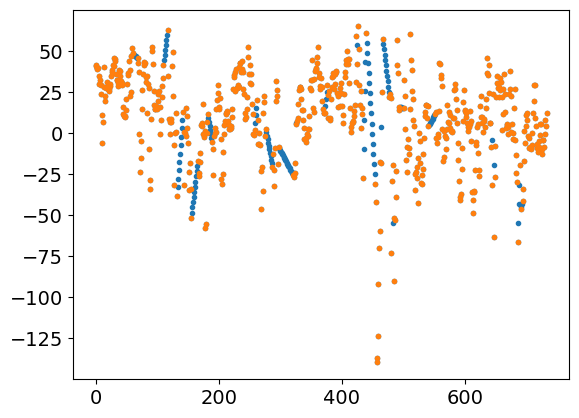

In [23]:
plt.plot(dummy,'.')
plt.plot(test,'.')


# Spectral analysis

## uniform FFT

In [6]:
# try xrft.power_spectrum

In [35]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [36]:
mask = ~np.isnan(u_detrended[:,10,10].interpolate_na(dim='time',method='linear'))
freq,ps,psd = spectrum1(u_detrended[:,10,10].interpolate_na(dim='time',method='linear')[mask])

## non-uniform FFT

In [3]:
def nufft(data,xarray_apply=True):
    '''
    does a non-uniform fast fourier transform on data with a uniform grid but nan values in it
    
    returns freq: frequency in cycles per timestep (cph for hourly data)
            f_k: amplitude for each wavenumber k as a complex number
            ps: power spectrum
            psd: power spectral density
            
    xarray_apply is used for the spectral_analysis function for apply_ufunc along time dimension for each point of spatial array
        if you just want to do it for one array time series, set it to False
    
    function is taken from https://github.com/jakevdp/nfft
    '''
    mask = ~np.isnan(data)
    
    N_freq = len(data)
    k = -N_freq//2 + np.arange(N_freq)
    
    data_masked = data[mask]
    t = np.linspace(0, 1,N_freq)[mask]
    
    f_k = nfft.nfft_adjoint(t,data_masked,N_freq)
    ps = np.abs(f_k)**2/N_freq**2
    psd = ps * N_freq
    freq = k/N_freq
    if xarray_apply == True:
        t_return = np.linspace(0, 1,N_freq)
        t_return[~mask] = np.nan
        return np.stack((freq,f_k,ps,psd,t_return),axis=-1)
    elif xarray_apply==False:
        return freq,f_k,ps,psd,t

In [4]:
def spectral_analysis(da):
    '''
    apply the nufft on each spatial point of a 2D dataset along the timeseries
    returns xarray DataSet with frequency spectrum, powerspectrum, power spectral density for each point
    t is masked time array without nans, necessary for reconstruction of time series from frequency spectrum
    '''
    dt = xr.apply_ufunc(
                nufft,
                da,
                input_core_dims=[['time']],
                output_core_dims=[['freq','dim0']],
                vectorize=True,
                output_dtypes=['complex'],
                dask="parallelized",
                dask_gufunc_kwargs={'output_sizes':{'freq':744,'dim0':5}}
            )
    dt = xr.Dataset(coords={
        'lat':(['y','x'],dt['lat'].data),
        'lon':(['y','x'],dt['lon'].data),
        'freq':np.real(dt[0,0,:,0].data)
    },data_vars={
        'f_k':(['y','x','freq'],dt.isel(dim0=1).data),
        'ps':(['y','x','freq'],np.real(dt.isel(dim0=2).data)),
        'psd':(['y','x','freq'],np.real(dt.isel(dim0=3).data)),
        't':(['y','x','freq'],np.real(dt.isel(dim0=4).data))
        

    })
    dt = dt.transpose('freq','y','x')
    # dt = dt.where(dt!=0)
    return dt

# hann = xr.DataArray(coords={'time':velocity.time.values},data=np.hanning(744))
# spectral_u_hann = spectral_analysis(velocity.u_demeaned*hann)

In [5]:
# spectral_u = spectral_analysis(velocity.u_detrended)
spectral_v = spectral_analysis(velocity.v_detrended)

spectral_v = spectral_v.where(spectral_v!=0)

spectral_v_nocomplex = spectral_v.copy()

spectral_v_nocomplex['f_k_real'] = np.real(spectral_v_nocomplex.f_k)
spectral_v_nocomplex['f_k_imag'] = np.imag(spectral_v_nocomplex.f_k)

spectral_v_nocomplex = spectral_v_nocomplex.drop(['f_k'])

spectral_v_nocomplex.to_netcdf(input_path + 'spectral_v.nc')

In [12]:
freq,f_k,ps,psd,t = nufft(velocity.v_detrended[:,12,28],xarray_apply=False)
# freq,f_k_filtered,ps_filtered,psd_filtered,data_reconstructed_filtered = nufft(velocity.u_filtered[:,12,28],xarray_apply=False)

In [20]:
freq_pos = freq[372:]

f_k_pos = np.ones((372))*f_k[372:]
f_k_pos[1:] = f_k_pos[1:]*2

ps_pos = np.ones((372))*ps[372:]
ps_pos[1:] = ps_pos[1:]*2

psd_pos = np.ones((372))*psd[372:]
psd_pos[1:] = psd_pos[1:]*2

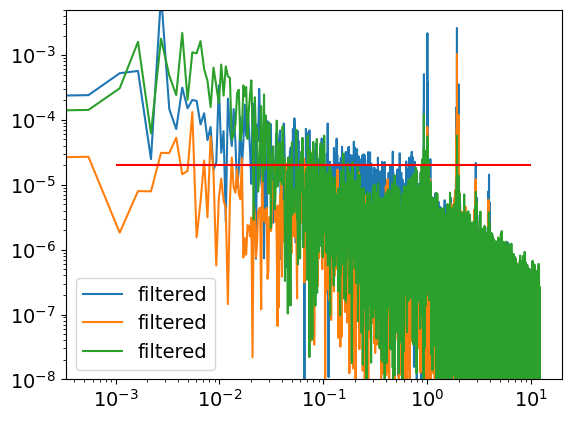

In [367]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

# plt.loglog(freq*24,ps,label='raw')
plt.loglog(spectral_u.freq*24,spectral_u.isel(x=28,y=12).ps,label='filtered')
plt.loglog(spectral_u.freq*24,spectral_u.isel(x=12,y=28).ps,label='filtered')


plt.loglog(spectral_u.freq*24,spectral_u.isel(x=10,y=10).ps,label='filtered')
# plt.loglog(spectral_u.isel(x=28,y=12).sel(freq=slice(9e-1/24,1.1/24)).freq*24,spectral_u.isel(x=28,y=12).sel(freq=slice(9e-1/24,1.1/24)).ps)
# plt.loglog(spectral_u_hann.isel(x=10,y=10).freq*24,spectral_u_hann.isel(x=10,y=10).ps,label='hann')
# plt.loglog(spectral_u.isel(x=10,y=10).freq*24,spectral_u.isel(x=10,y=10).ps,label='detrend')

ymin,ymax = 1e-8,5e-3
# plt.vlines([f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
# plt.vlines([1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
# plt.vlines([2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
# plt.vlines([2.8e-3],ymin,ymax,color=['y'],linestyle='--',label='seasonal')

# plt.vlines(spectral_u.freq[test[0]+idx].data*24,ymin,ymax,color='k')
plt.legend(loc='lower left')
plt.ylim([ymin,ymax]);

plt.hlines(2e-5,1e-3,10,color='r')
# plt.savefig('/Users/2311043/Documents/GitHub/TORI/spectrum_filtervsraw.png')

## find peaks

In [338]:
def peak_finder(freq_data,ps_data,freq_min,freq_max,peak_height):
    freq_mask = np.array([freq_data > freq_min]) & np.array([freq_data < freq_max])
    freq_mask = np.squeeze(freq_mask)
    peaks,peak_heights = scipy.signal.find_peaks(ps_data[freq_mask],height=peak_height)
    freq_peaks = freq_data[freq_mask][peaks]
    freq_avg = np.mean(freq_peaks)
    peak_avg = np.mean(peak_heights['peak_heights'])
    return np.array([freq_avg,peak_avg])

In [397]:
def find_peaks_xr(data,freq_min,freq_max,peak_height):
    ds = xr.apply_ufunc(
                peak_finder,
                data.freq,
                data.ps,
                freq_min,
                freq_max,
                peak_height,
                input_core_dims=[['freq'],['freq'],[],[],[]],
                output_core_dims=[['peak']],
                vectorize=True,
                output_dtypes=['float'],
                dask="parallelized",
                dask_gufunc_kwargs={'output_sizes':{'peak':2}}
            )
    return ds


diurnal_u = find_peaks_xr(spectral_u,freq_min=0.9/24,freq_max=1.1/24,peak_height=2e-5)
semidiurnal_u = find_peaks_xr(spectral_u,freq_min=1.9/24,freq_max=2.1/24,peak_height=2e-5)

diurnal_v = find_peaks_xr(spectral_v,freq_min=0.9/24,freq_max=1.1/24,peak_height=2e-5)
semidiurnal_v = find_peaks_xr(spectral_v,freq_min=1.9/24,freq_max=2.1/24,peak_height=2e-5)

C:\Users\2311043\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\2311043\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### u

(Text(0.5, 1.0, 'diurnal amplitude/threshold'),
 Text(0.5, 1.0, 'semidiurnal amplitude/threshold'))

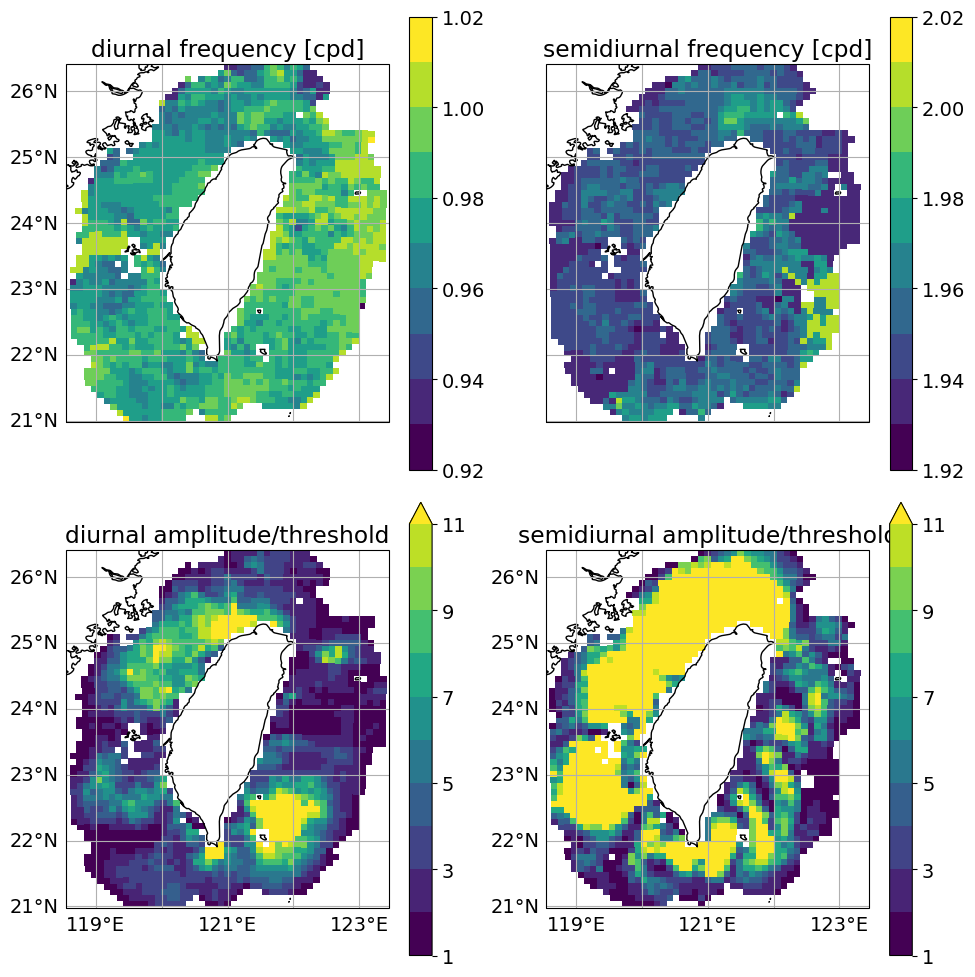

In [395]:
fig, axs = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()},sharex=True,sharey=True)
axs=axs.ravel()
(diurnal_u[:,:,0]*24).plot(x='lon',y='lat',ax=axs[0],levels=np.arange(0.92,1.03,0.01))
(diurnal_u[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[2],levels=np.arange(1,12,1))

(semidiurnal_u[:,:,0]*24).plot(x='lon',y='lat',ax=axs[1],levels=np.arange(1.92,2.03,0.01))
(semidiurnal_u[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[3],levels=np.arange(1,12,1))

for ax in axs:
    ax.coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False;gl0.right_labels=False;gl0.bottom_labels=False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False;gl1.right_labels=False;gl1.bottom_labels=False;gl1.left_labels=False

gl2 = axs[2].gridlines(draw_labels=True)
gl2.top_labels=False;gl2.right_labels=False

gl3 = axs[3].gridlines(draw_labels=True)
gl3.top_labels=False;gl3.right_labels=False

fig.tight_layout()
axs[0].set_title('diurnal frequency [cpd]'),axs[1].set_title('semidiurnal frequency [cpd]')
axs[2].set_title('diurnal amplitude/threshold'),axs[3].set_title('semidiurnal amplitude/threshold')

### v

(Text(0.5, 1.0, 'diurnal amplitude/threshold'),
 Text(0.5, 1.0, 'semidiurnal amplitude/threshold'))

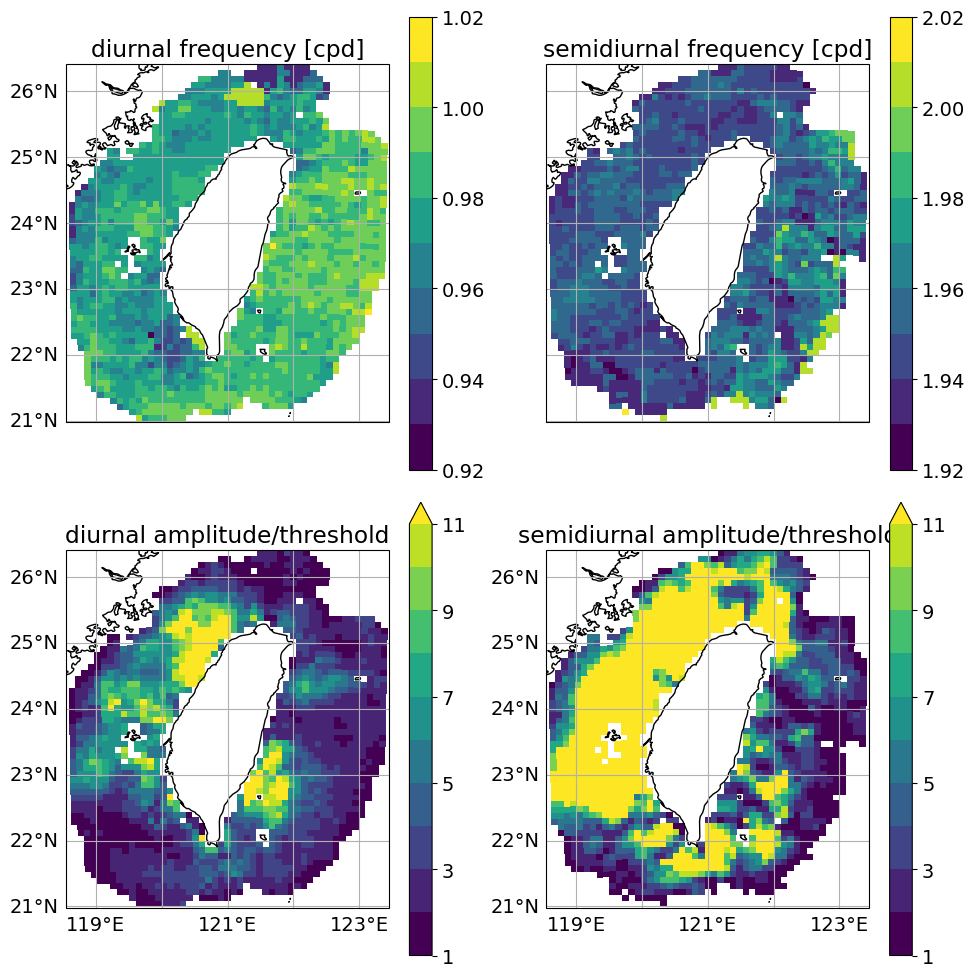

In [398]:
fig, axs = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()},sharex=True,sharey=True)
axs=axs.ravel()
(diurnal_v[:,:,0]*24).plot(x='lon',y='lat',ax=axs[0],levels=np.arange(0.92,1.03,0.01))
(diurnal_v[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[2],levels=np.arange(1,12,1))

(semidiurnal_v[:,:,0]*24).plot(x='lon',y='lat',ax=axs[1],levels=np.arange(1.92,2.03,0.01))
(semidiurnal_v[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[3],levels=np.arange(1,12,1))

for ax in axs:
    ax.coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False;gl0.right_labels=False;gl0.bottom_labels=False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False;gl1.right_labels=False;gl1.bottom_labels=False;gl1.left_labels=False

gl2 = axs[2].gridlines(draw_labels=True)
gl2.top_labels=False;gl2.right_labels=False

gl3 = axs[3].gridlines(draw_labels=True)
gl3.top_labels=False;gl3.right_labels=False

fig.tight_layout()
axs[0].set_title('diurnal frequency [cpd]'),axs[1].set_title('semidiurnal frequency [cpd]')
axs[2].set_title('diurnal amplitude/threshold'),axs[3].set_title('semidiurnal amplitude/threshold')

## Rotary spectrum

In [5]:
spectral_rotary = spectral_analysis(velocity.u_detrended+1j*velocity.v_detrended)

spectral_rotary = spectral_rotary.where(spectral_rotary!=0)

spectral_rotary_nocomplex = spectral_rotary.copy()

spectral_rotary_nocomplex['f_k_real'] = np.real(spectral_rotary_nocomplex.f_k)
spectral_rotary_nocomplex['f_k_imag'] = np.imag(spectral_rotary_nocomplex.f_k)

spectral_rotary_nocomplex = spectral_rotary_nocomplex.drop(['f_k'])

spectral_rotary_nocomplex.to_netcdf(input_path + 'spectral_rotary.nc')

In [12]:
freq,f_k,ps,psd,t = nufft(velocity.u_detrended[:,28,12]+1j*velocity.v_detrended[:,28,12],xarray_apply=False)
# freq,f_k_filtered,ps_filtered,psd_filtered,t = nufft(velocity.u_filtered[:,10,10]+1j*velocity.v_filtered[:,10,10],xarray_apply=False)

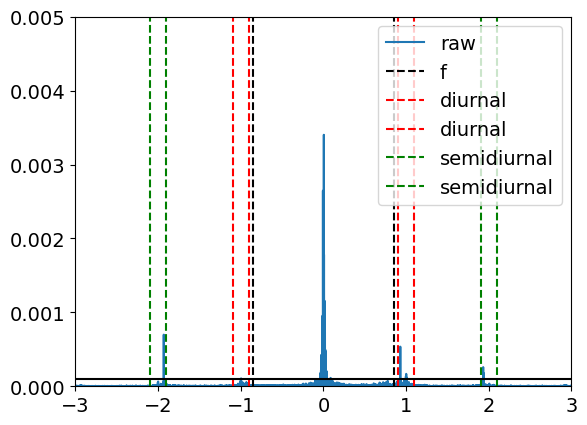

In [415]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

plt.plot(spectral_rotary.freq*24,spectral_rotary.isel(x=10,y=10).ps,label='raw')
# plt.plot(freq*24,ps_filtered,label='filtered')

plt.xlim([-3,3])
ymin,ymax = 0,0.005
plt.vlines([f_coriolis,-f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
# plt.vlines([1,-1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([0.9,1.1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([-0.9,-1.1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')

# plt.vlines([2,-2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([2.1,-2.1],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([1.9,-1.9],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')

plt.hlines(1e-4,-3,3,color='k')
plt.legend()
plt.ylim([ymin,ymax]);

# plt.savefig('/Users/2311043/Documents/GitHub/TORI/spectrum_rotary.png')

In [422]:
def peak_finder_rot(freq_data,ps_data,freq_min,freq_max,peak_height):
    freq_mask = (np.array([freq_data > freq_min]) & np.array([freq_data < freq_max])) + (np.array([freq_data < -freq_min]) & np.array([freq_data > -freq_max]))
    freq_mask = np.squeeze(freq_mask)
    peaks,peak_heights = scipy.signal.find_peaks(ps_data[freq_mask],height=peak_height)
    freq_peaks = freq_data[freq_mask][peaks]
    freq_avg = np.mean(np.abs(freq_peaks))
    peak_avg = np.mean(peak_heights['peak_heights'])
    return np.array([freq_avg,peak_avg])

In [423]:
def find_peaks_rot_xr(data,freq_min,freq_max,peak_height):
    ds = xr.apply_ufunc(
                peak_finder_rot,
                data.freq,
                data.ps,
                freq_min,
                freq_max,
                peak_height,
                input_core_dims=[['freq'],['freq'],[],[],[]],
                output_core_dims=[['peak']],
                vectorize=True,
                output_dtypes=['float'],
                dask="parallelized",
                dask_gufunc_kwargs={'output_sizes':{'peak':2}}
            )
    return ds


diurnal_rot = find_peaks_rot_xr(spectral_rotary,freq_min=0.9/24,freq_max=1.1/24,peak_height=1e-4)
semidiurnal_rot = find_peaks_rot_xr(spectral_rotary,freq_min=1.9/24,freq_max=2.1/24,peak_height=1e-4)

C:\Users\2311043\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\2311043\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(Text(0.5, 1.0, 'diurnal amplitude/threshold'),
 Text(0.5, 1.0, 'semidiurnal amplitude/threshold'))

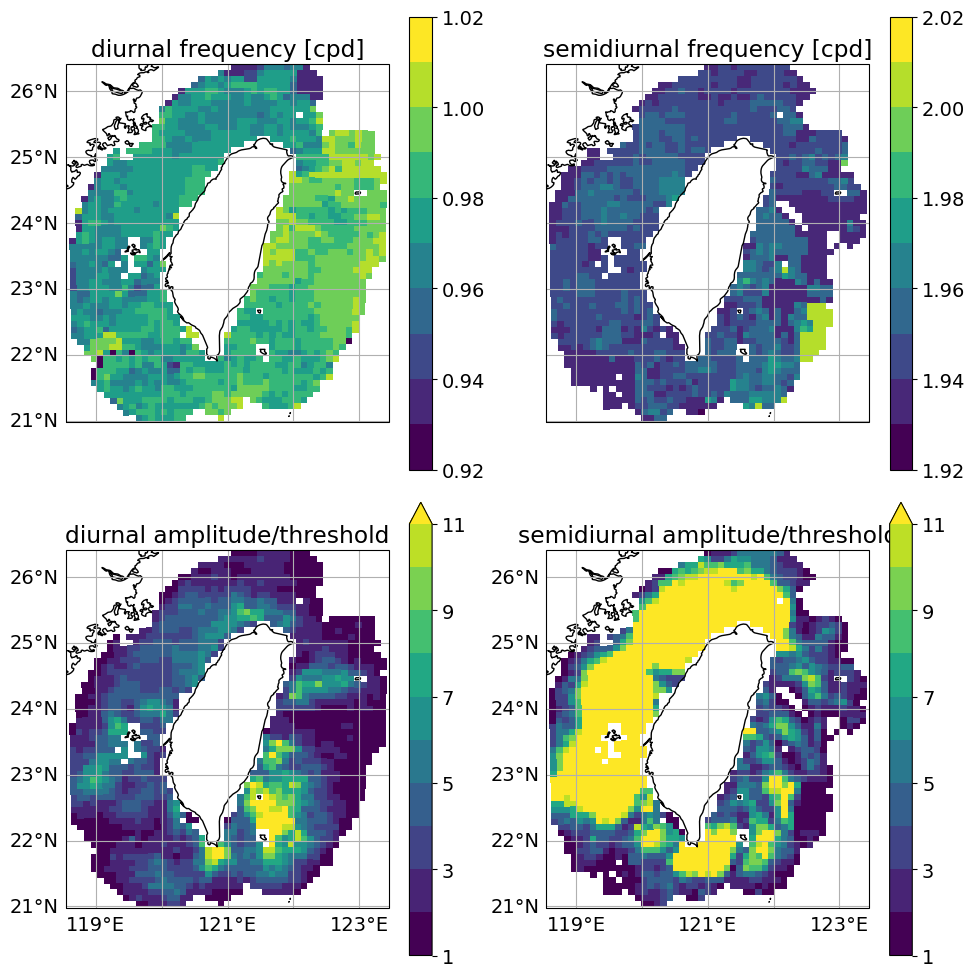

In [424]:
fig, axs = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()},sharex=True,sharey=True)
axs=axs.ravel()
(diurnal_rot[:,:,0]*24).plot(x='lon',y='lat',ax=axs[0],levels=np.arange(0.92,1.03,0.01))
(diurnal_rot[:,:,1]/1e-4).plot(x='lon',y='lat',ax=axs[2],levels=np.arange(1,12,1))

(semidiurnal_rot[:,:,0]*24).plot(x='lon',y='lat',ax=axs[1],levels=np.arange(1.92,2.03,0.01))
(semidiurnal_rot[:,:,1]/1e-4).plot(x='lon',y='lat',ax=axs[3],levels=np.arange(1,12,1))

for ax in axs:
    ax.coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False;gl0.right_labels=False;gl0.bottom_labels=False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False;gl1.right_labels=False;gl1.bottom_labels=False;gl1.left_labels=False

gl2 = axs[2].gridlines(draw_labels=True)
gl2.top_labels=False;gl2.right_labels=False

gl3 = axs[3].gridlines(draw_labels=True)
gl3.top_labels=False;gl3.right_labels=False

fig.tight_layout()
axs[0].set_title('diurnal frequency [cpd]'),axs[1].set_title('semidiurnal frequency [cpd]')
axs[2].set_title('diurnal amplitude/threshold'),axs[3].set_title('semidiurnal amplitude/threshold')

# tidal ellipse

In [425]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.unravel_index(np.abs(array - value).argmin(), array.shape)
    return array[idx],idx

In [426]:
def ellipse_details(fm,fp):
    Rp = np.abs(fp) + np.abs(fm)
    Rm = np.abs(np.abs(fp) - np.abs(fm))

    major = np.abs(Rp + Rm)
    minor = np.abs(Rp - Rm)

    azimuth = cmath.phase(fp*fm)/2
    return major,minor,azimuth

In [430]:
value,f_index = find_nearest(spectral_rotary.freq*24,1)

In [436]:
x=10;y=10
fm,fp = spectral_rotary.isel(freq=[43824-f_index[0],f_index[0]],x=x,y=y).f_k

In [437]:
ellipse_details(fm,fp)

(<xarray.DataArray 'f_k' ()>
 array(879.45198365)
 Coordinates:
     lat      float64 21.94
     lon      float64 119.6,
 <xarray.DataArray 'f_k' ()>
 array(307.90133592)
 Coordinates:
     lat      float64 21.94
     lon      float64 119.6,
 -0.7853981633974483)

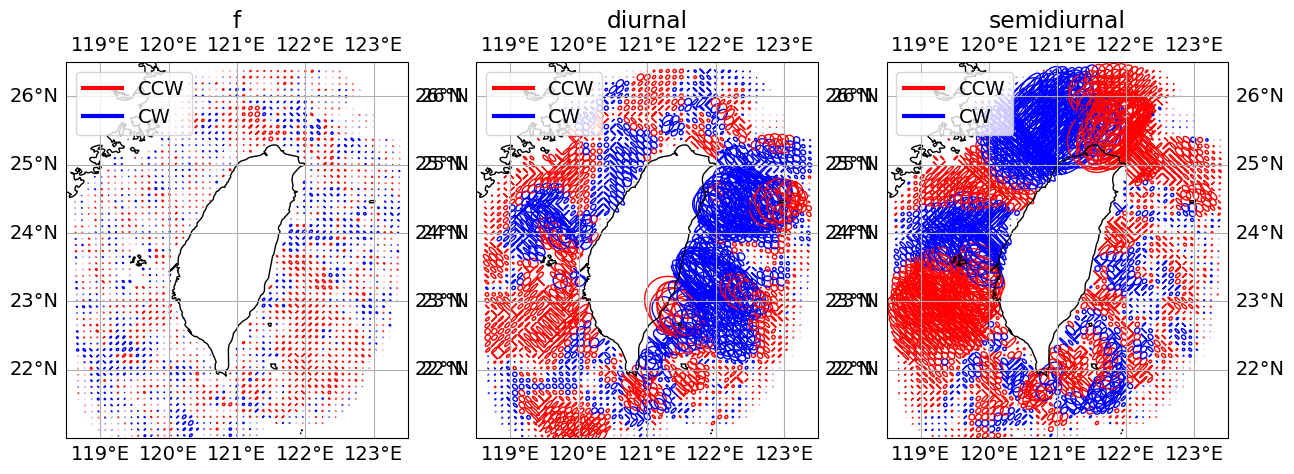

In [447]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24
colors = ['r', 'b']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = [ 'CCW', 'CW']

fig, axs = plt.subplots(1,3,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

for ax,f,title in zip(axs.ravel(),[f_coriolis,1,2],['f','diurnal','semidiurnal']):
    value,f_index = find_nearest(spectral_rotary.freq*24,f)
    for x in range(49):
        for y in range(60):
            fm,fp = spectral_rotary.isel(freq=[43824-f_index[0],f_index[0]],x=x,y=y).f_k
            if ~np.isnan(np.abs(fm)):
                major,minor,azimuth = ellipse_details(fm,fp)
                lonlat = [fm.lon.data ,  fm.lat.data]
                rot = int(np.abs(fp).data > np.abs(fm).data)
                ell = mpl.patches.Ellipse(xy=lonlat, width=major/1e4, height=minor/1e4, angle = azimuth*180/np.pi,fc='none',ec=['b','r'][rot],transform=ccrs.PlateCarree())

                ax.add_patch(ell)
            else:
                continue
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_aspect('equal')
    ax.autoscale()
    ax.set_title(title)
    ax.legend(lines,labels,loc='upper left')
    ax.set_extent([118.5,123.5,21,26.5])
# plt.savefig('/Users/2311043/Documents/GitHub/TORI/tidal_ellipses.png')

# time filtering

In [3]:
def hann_window(T,n):
    '''
    calculates the frequency spectrum of a hanning window for n samples leading to n frequencies and T window size
    n has to be integer and n % 2 has to be 0
    '''
    assert n%2==0
    w = np.hanning(T)
    w = w / w.sum()
    freq_hann = np.fft.fftfreq(n)

    w_transform = np.abs(np.fft.fft(w, n=n))
    mid_index = int(n/2)
    amp_hann = np.concatenate((w_transform[mid_index:],w_transform[:mid_index]))
    freq_hann = np.concatenate((freq_hann[mid_index:],freq_hann[:mid_index]))
    return freq_hann,amp_hann

In [4]:
def drop_na(data):
    mask = ~np.isnan(data)
    return data[mask]

In [5]:
def inverse_nufft(t,f_k):
    '''
    inverse fourier transform to get back time series from fourier components
    non-uniform discrete fourier transform
    
    returns array of reconstructed velocities on the complete time grid, so with nan values
    '''
    reconstructed = nfft.nfft(drop_na(t), f_k)/len(f_k)
    reconstructed_ontime = np.copy(t)
    reconstructed_ontime[~np.isnan(t)] = reconstructed
    return reconstructed_ontime

# def inverse_nufft_hann(data,amp_hann):
#     reconstructed = nfft.nfft(drop_na(data.t), data.f_k*amp_hann)/len(data.f_k)
#     reconstructed_ontime = np.copy(data.t)
#     reconstructed_ontime[~np.isnan(data.t)] = reconstructed
#     return reconstructed_ontime

def inverse_nufft_hann(t,f_k,amp_hann):
    '''
    inverse fourier transform to get back time series from fourier components
    non-uniform discrete fourier transform but with amplitude taken out of high frequencies using a hanning window, which has to be predefined
    
    returns array of reconstructed velocities on the complete time grid, so with nan values
    '''
    reconstructed = nfft.nfft(drop_na(t), f_k*amp_hann)/len(f_k)
    reconstructed_ontime = np.copy(t)
    reconstructed_ontime[~np.isnan(t)] = reconstructed
    return reconstructed_ontime

In [21]:
freq_hann,amp_hann = hann_window(49,43824)

data_rec = inverse_nufft(spectral_v.isel(x=10,y=10).t,spectral_v.isel(x=10,y=10).f_k)
data_filtered = inverse_nufft_hann(spectral_v.isel(x=10,y=10).t,spectral_v.isel(x=10,y=10).f_k,amp_hann)

C:\Users\2311043\AppData\Local\Temp\ipykernel_15420\3398310591.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructed_ontime[~np.isnan(t)] = reconstructed
C:\Users\2311043\AppData\Local\Temp\ipykernel_15420\3398310591.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructed_ontime[~np.isnan(t)] = reconstructed


In [6]:
def filter_hann_window(spectral_data,T):
    '''
    apply inverse nufft on 2D xarray dataset with a hanning frequency filter applied
    returns xarray DataArray of reconstructed filtered velocities on each point in space
    '''
    freq_hann,amp_hann = hann_window(T,len(spectral_data.freq))
    dt = xr.apply_ufunc(
                inverse_nufft_hann,
                spectral_data.t,
                spectral_data.f_k,
                amp_hann,
                input_core_dims=[['freq'],['freq'],['time']],
                output_core_dims=[['time']],
                vectorize=True,
                output_dtypes=[np.dtype(float)],
                dask="parallelized",
            )
    dt = dt.transpose('time','y','x').assign_coords({'time':velocity.time.values})
    return dt

# velocity['u_filtered'] = filter_hann_window(spectral_u,49)
velocity['v_filtered'] = filter_hann_window(spectral_v,49)

C:\Users\2311043\AppData\Local\Temp\ipykernel_4084\3398310591.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructed_ontime[~np.isnan(t)] = reconstructed


In [7]:
velocity['v_filtered'].to_netcdf(input_path + 'v_filtered.nc')

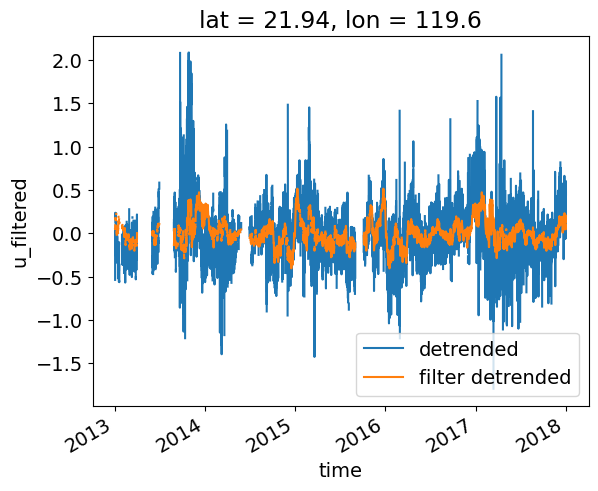

In [7]:
velocity.isel(x=10,y=10).u_detrended.plot(label='detrended')

(velocity.isel(x=10,y=10).u_filtered).plot(label='filter detrended')
# velocity.isel(x=20,y=10).u_filtered_hann.plot(label='filter hann')
# velocity.isel(x=20,y=10).u_demeaned.plot(label='demeaned')
# plt.plot(spectral_v.isel(x=10,y=10).t,data_rec)
# plt.plot(spectral_v.isel(x=10,y=10).t,data_filtered)

plt.legend()
# plt.savefig('/Users/2311043/Documents/GitHub/TORI/time_filter.png')

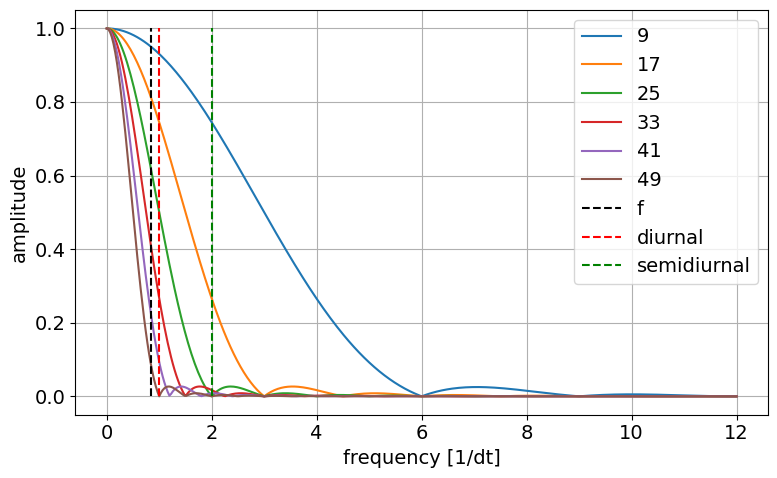

In [54]:
n = 744
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
axs = [axs]
# axs[0].plot(freq_pos*24,ps_pos/ps_pos.max(),label='power spectrum')

for k in np.arange(4, 28, 4):
    T = 2 * k + 1
#     w = np.zeros(n)
#     w[n//2 - k : n//2+k+1] = np.hanning(T)
    w = np.hanning(T)
    w = w / w.sum()
    freq_hann = np.fft.rfftfreq(n)
    w_transform = np.fft.rfft(w, n=n)
#     w_transform = np.ones_like(freq)
#     w_transform = (
#         0j 
#         + .5 * T * np.sinc(freq * T)
#         + .25 * T * np.sinc(T * (freq - 1 / T))
#         + .25 * T * np.sinc(T * (freq + 1 / T))
#     )
    w_transform /= w_transform[0]
    w_power = w_transform * w_transform.conj()

    plt.sca(axs[0])
    plt.plot(freq_hann*24, np.abs(w_transform),label=str(T))
    
#     plt.sca(axs[1])
#     plt.plot(freq, np.angle(w_transform), )

axs[0].set(ylabel='amplitude', xlabel='frequency [1/dt]')
axs[0].grid()

ymin,ymax = 0,1
plt.vlines([f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.legend()

# axs[1].set(ylabel='phase')
# axs[1].grid()
plt.tight_layout();
# plt.savefig('../img/9_filtering_4.svg', bbox_inches='tight', pad_inches=.1);

# Section Extraction

In [9]:
from math import radians, cos, sin, asin, sqrt

def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.unravel_index(np.abs(array - value).argmin(), array.shape)
    return array[idx],idx

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

def section_indices(data,point1,point2):
    lat = np.asarray(data.lat.data)
    lon = np.asarray(data.lon.data)
    
    lat1,lon1 = point1
    lat2,lon2 = point2
    

    f = np.frompyfunc(haversine,4,1)
    value, indices1 = find_nearest(f(lon,lat,lon1,lat1).astype(float),0)
    value, indices2 = find_nearest(f(lon,lat,lon2,lat2).astype(float),0)

    x_dist = np.abs(indices1[1] - indices2[1]) + 1
    y_dist = np.abs(indices1[0] - indices2[0]) + 1

    dist_max = max(x_dist,y_dist)

    latitudes = np.linspace(lat1, lat2, dist_max)  # ten points
    longitudes = (lon2 - lon1)/(lat2 - lat1)*(latitudes - lat1) + lon1

    x_idx = []
    y_idx = []


    for i in range(dist_max):
        dummy = find_nearest(f(lon,lat,longitudes[i],latitudes[i]).astype(float),0)[1]
        x_idx.append(dummy[1])
        y_idx.append(dummy[0])
        
    return x_idx,y_idx,latitudes,longitudes

In [80]:
point1 = (25.5,119.8)
point2 = (25.1,121)

x_idx,y_idx,latitudes,longitudes = section_indices(velocity,point1,point2)

section = velocity.isel(x=xr.DataArray(x_idx, dims="s"), y=xr.DataArray(y_idx, dims="s"))

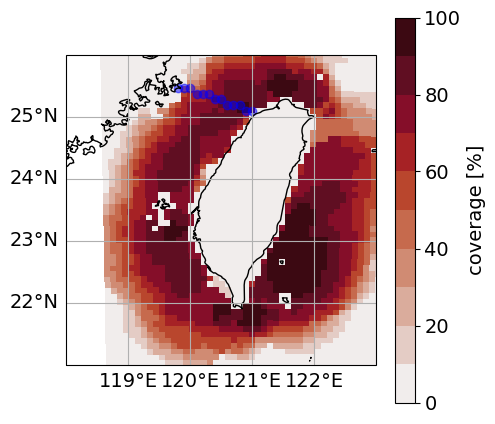

In [100]:
fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})

(velocity.coverage*100).plot(ax=ax1,x='lon',y='lat',levels=np.arange(0,110,10),cmap=cmo.amp,cbar_kwargs={'label':'coverage [%]'})

ax1.set_extent([118,123,21,26])
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

xr.plot.scatter(ds=section,x='lon',y='lat',color='b',alpha=0.5)

# rotate velocities

In [101]:
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [102]:
def rotate_velocities(u,v,angle):

    angle = -(angle- np.pi/2)
    
    u_ = u * np.cos(angle) - v * np.sin(angle)
    v_ = u * np.sin(angle) + v * np.cos(angle)
    
    return u_,v_

In [108]:
section['cross_vel'],section['along_vel'] = rotate_velocities(section.u_filtered,section.v_filtered,np.deg2rad(calculate_initial_compass_bearing(point1,point2)))

In [112]:
mean = section.mean(dim='time')

u_std = section.along_vel.std(dim='time')
v_std = section.cross_vel.std(dim='time')

In [139]:

fig,ax= plt.subplots(1,1,figsize=(10,10))
for s in range(12):
    mean.isel(s=s).plot.quiver(ax=ax,x='lon',y='lat',u='along_vel',v='cross_vel',scale=0.1)
    ell = mpl.patches.Ellipse(xy=[section.isel(s=s).lon,section.isel(s=s).lat],
                          width=u_std.isel(s=s)/10, height=v_std.isel(s=s)/10, angle = -np.deg2rad(calculate_initial_compass_bearing(point1,point2)),fc='none',ec='k')
    ax.add_patch(ell)
    # ax.set_aspect('equal')
    # ax.autoscale()

ValueError: need at least one array to concatenate

<Figure size 1000x1000 with 1 Axes>

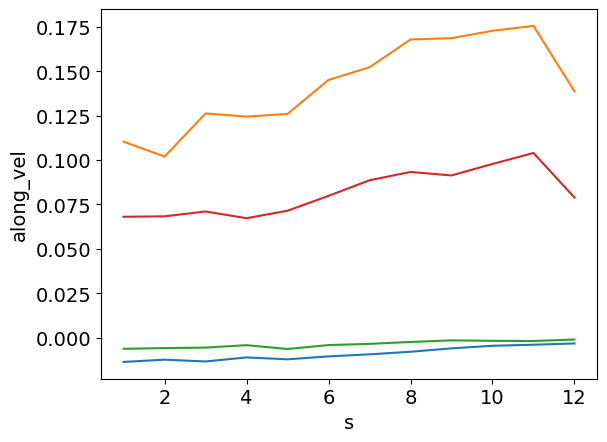

In [110]:
section.mean(dim='time').cross_vel.plot()
section.std(dim='time').cross_vel.plot()

section.mean(dim='time').along_vel.plot()
section.std(dim='time').along_vel.plot()